Task Description
The goal is to create a differentiable gaussian blur filter for pytorch and use
it to estimate the amount of blur on the provided images.
Gaussian blur (also called gaussian filtering) is a 2d convolution hence a pytorchs
Conv2d would be appropriate to use.
Note that you do not want to estimate a full (arbitrary) 2D convolution kernel but
just the blur amount, which is given by sigma. Hence torch.nn.functional.conv2d() should
be used, where the weights are defined by the gaussian kernel.

Please implement, in pytorch:

1) a gaussian blur function.
2) apply this function to the included input.png image with some sigma, to check that it
indeed blurs the image.
3) calculate the loss between the blurred.png image and the blur you apply to input.png.
4) make certain that the function is differentiable with respect to the blur strength (sigma)
by checking the gradient for the sigma parameter is non-negative when doing backpropagation on
the loss calculated above.
5) estimate the correct sigma which was used to generate blur.png from input.png, by optimizing
sigma using e.g. Adam or SGD.

While doing this please:

Please frequently commit meaningful intermediate steps and mention (e.g. in the commit message)
or document (e.g. in a markdown log file) issues you found, or whenever you solved a bug.
If you can't solve some step, please write down what you think where the problem likely is
and how you would proceed solving it (e.g. researching some topic, trying out certain experiments).
You may use any method and shortcut to solve this task that you would also use at work
(e.g. searching google, stackoverflow), but you must implement the function yourself.

Performing blurring using pytorch class method
1) At first, used using scipy.ndimage to setup the kernel
2) found code: https://discuss.pytorch.org/t/is-there-anyway-to-do-gaussian-filtering-for-an-image-2d-3d-in-pytorch/12351/9 , which uses the forumula to define the gaussian kernel
3) The kernels are slightly different (my_model.conv2d_weight for the two situations) and the corresponding predicted blurred image tensor also changes (yhat). But they both blur the images as expected.



Issues resolved in this part
1) Figure out the dimensions of the input and kernel tensors
2) Convert from cv to the tensor format for pytorch (used transforms)
3) Understanding groups variable
4) Problem during actual conv2d step as tensor for input image was float, but gaussian kernel was double. So had to make them match first.
5) Padding calculation to make the output dimensions after conv2d match the input dimensions  


About gaussian kernel size estimation etc.
https://blog.demofox.org/2015/08/19/gaussian-blur/

## create and activate the environment
cd ~/.venvPython
python3 -m venv myNewEnv1
source ~/.venvPython/myNewEnv1/bin/activate

## install packages
pip3 install jupyter
pip3 install pandas
	as per https://pytorch.org/, for cpu version of pytorch says to install as follows:
pip3 install torch==1.8.1+cpu torchvision==0.9.1+cpu torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html
pip3 install torchsummary
pip3 install opencv-python ## but note this one does not have non-free algos
pip3 install matplotlib
#pip3 install scipy
#pip3 install scikit-learn
#pip3 install scikit-image

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchsummary import summary

import math
import numbers
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/gdrive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/gdrive


In [3]:
!ls

gdrive	sample_data


In [4]:
!ls './gdrive/My Drive/PyTorchBlur/'

blurred.png  input.png


In [5]:
HOMEDIR = r'/content/gdrive/My Drive/PyTorchBlur/'

In [6]:
os.listdir(HOMEDIR)

['input.png', 'blurred.png']

In [7]:
def read_image(path):
    img = cv2.imread(path)
    #img = np.array(img[:, :, ::-1]) # alternative way to convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    return img

In [8]:
ipimg = read_image(HOMEDIR + 'input.png')      # (H，W，3） cv2:(B,G,R)
blurimg_gt = read_image(HOMEDIR + 'blurred.png')  # (H，W，3） cv2:(B,G,R)
print(f"ipimg.shape = {ipimg.shape}, blurimg_gt.shape = {blurimg_gt.shape}")

ipimg_t = torch.from_numpy(ipimg)
blurimg_gt_t = torch.from_numpy(blurimg_gt)
print(f"ipimg_t.shape = {ipimg_t.shape}, blurimg_gt_t.shape = {blurimg_gt_t.shape}")
print(f"ipimg_t.dtype = {ipimg_t.dtype}, blurimg_gt_t.dtype = {blurimg_gt_t.dtype}")

ipimg.shape = (1375, 918, 3), blurimg_gt.shape = (1375, 918, 3)
ipimg_t.shape = torch.Size([1375, 918, 3]), blurimg_gt_t.shape = torch.Size([1375, 918, 3])
ipimg_t.dtype = torch.uint8, blurimg_gt_t.dtype = torch.uint8


In [11]:
## using torchvision.transforms moves channels to the first dimension as required
# https://discuss.pytorch.org/t/dimensions-of-an-input-image/19439
## need to make the input image as per how pytorch required:
##      In PyTorch, images are represented as [channels, height, width], so a color image would be [3, 256, 256].
##      During the training you will get batches of images, so your shape in the forward method will get an
##        additional batch dimension at dim0: [batch_size, channels, height, width].


# https://www.programmersought.com/article/4469534250/
## transforms.ToTensor()
## (1) transforms.ToTensor() Converts a picture read by numpy's ndarray or PIL.Image into a Tensor format of 
##     shape (C, H, W) with /255 normalization Between [0,1.0]
## (2) The specific order of the channel is related to the cv2 read or the picture read by PIL.Image
## cv2:(B,G,R)
## PIL.Image:(R, G, B)

ipimg_t = transforms.ToTensor()(ipimg)
blurimg_gt_t = transforms.ToTensor()(blurimg_gt)

print(f"ipimg_t.shape = {ipimg_t.shape}, blurimg_gt_t.shape = {blurimg_gt_t.shape}")
print(f"ipimg_t size = {ipimg_t.size()}")  # (C,H, W), channel order (B, G, R)
print(f"blurimg_gt_t size = {blurimg_gt_t.size()}")  # (C,H, W), channel order (B, G, R)
print(f"ipimg_t.dtype = {ipimg_t.dtype}, blurimg_gt_t.dtype = {blurimg_gt_t.dtype}")

ipimg_t.shape = torch.Size([3, 1375, 918]), blurimg_gt_t.shape = torch.Size([3, 1375, 918])
ipimg_t size = torch.Size([3, 1375, 918])
blurimg_gt_t size = torch.Size([3, 1375, 918])
ipimg_t.dtype = torch.float32, blurimg_gt_t.dtype = torch.float32


In [12]:
## make 4-dim
ipimg_t = ipimg_t.unsqueeze(0)
blurimg_gt_t = blurimg_gt_t.unsqueeze(0)

## convert to double
## to prevent the error: Input type (torch.FloatTensor) and weight type (torch.DoubleTensor) should be the same
##    during convolution operation, convert the ipimg tensor from float to double,
##    as the weights tensor is a double.
## same for the blurimg_gt_t
ipimg_t = ipimg_t.type(torch.DoubleTensor)
blurimg_gt_t = blurimg_gt_t.type(torch.DoubleTensor)

print(f"ipimg_t.shape = {ipimg_t.shape}, blurimg_gt_t.shape = {blurimg_gt_t.shape}")
print(f"ipimg_t size = {ipimg_t.size()}")  # (C,H, W), channel order (B, G, R)
print(f"blurimg_gt_t size = {blurimg_gt_t.size()}")  # (C,H, W), channel order (B, G, R)
print(f"ipimg_t.dtype = {ipimg_t.dtype}, blurimg_gt_t.dtype = {blurimg_gt_t.dtype}")

ipimg_t.shape = torch.Size([1, 3, 1375, 918]), blurimg_gt_t.shape = torch.Size([1, 3, 1375, 918])
ipimg_t size = torch.Size([1, 3, 1375, 918])
blurimg_gt_t size = torch.Size([1, 3, 1375, 918])
ipimg_t.dtype = torch.float64, blurimg_gt_t.dtype = torch.float64


In [13]:
def plot_three_imgs(_orig, _blur_gt, _blur_curr, _curr_sigma):
    fig, axes = plt.subplots(1, 3, figsize=(15,15))
    axes[0].imshow(ipimg)
    axes[0].title.set_text('original input')
    axes[1].imshow(_blur_gt)
    axes[1].title.set_text('blurred ground truth')
    axes[2].imshow(_blur_curr)
    axes[2].title.set_text(f'blurred current sigma={_curr_sigma}')
    plt.show()

In [15]:
class GaussianSmoothing(nn.Module):
    """
    1) function make_gaussian_filter_FINAL(): uses the gaussian_filter from scipy.ndimage
    2) function internet_make_gaussian(): explicity defines the gaussian filter code
       code found here: https://discuss.pytorch.org/t/is-there-anyway-to-do-gaussian-filtering-for-an-image-2d-3d-in-pytorch/12351/9
    """
    def __init__(self, _kernel_size_number, _in_sigma, _conv2d_stride, _conv2d_padding,
                _conv2d_bias, _conv2d_dilation, _conv2d_groups,
                _conv2d_weight=None):
        super(GaussianSmoothing, self).__init__()
        
        g_kernel = self.internet_make_gaussian(_kernel_size_number, _in_sigma)
        
        #self.register_buffer('weight', g_kernel)
        self.conv2d_weight = g_kernel
        
        self.conv2d_bias = _conv2d_bias
        self.conv2d_stride = _conv2d_stride
        self.conv2d_padding = _conv2d_padding
        self.conv2d_dilation  = _conv2d_dilation
        self.groups = _conv2d_groups

        self.conv1 = F.conv2d
    
    def internet_make_gaussian(self, _kernel_size_number, _in_sigma, _dim=2, _channels=3):
        ## from https://discuss.pytorch.org/t/is-there-anyway-to-do-gaussian-filtering-for-an-image-2d-3d-in-pytorch/12351/9
        
        if isinstance(_kernel_size_number, numbers.Number):
            kernel_size = [_kernel_size_number] * _dim
        if isinstance(_in_sigma, numbers.Number):
            sigma = [_in_sigma] * _dim

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        meshgrids = torch.meshgrid(
            [
                torch.arange(size, dtype=torch.float64)
                for size in kernel_size
            ]
        )
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / std) ** 2 / 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(_channels, *[1] * (kernel.dim() - 1))
        print(f"for sigma = {_in_sigma}, gaussian kernel size = {kernel.shape}")
        return kernel

    def forward(self, x):
        ## using register buffer - self.register_buffer('weight', g_kernel)
        #return self.conv(input, weight=self.weight, groups=self.groups, padding=self.conv2d_padding,
        #                stride=self.conv2d_stride)
        ## using self.variable
        return self.conv1(x, weight=self.conv2d_weight, groups=self.groups, padding=self.conv2d_padding,
                        stride=self.conv2d_stride)

In [16]:
current_sigma = 0.0001
## 2 * roundUp(sigma) * 3 + 1
calc_kernel_size = 2*math.ceil(current_sigma)*3 + 1
print(f"with Sigma = {current_sigma} , calculated kernel size = {calc_kernel_size}")

with Sigma = 0.0001 , calculated kernel size = 7


In [17]:
conv2d_bias = None
conv2d_stride = 1
#conv2d_padding = 3
conv2d_padding = (calc_kernel_size - 1) // 2
print(f"calculated kernel size = {calc_kernel_size} , calculated padding = {conv2d_padding}")
conv2d_dilation = 1
conv2d_groups = 3

calculated kernel size = 7 , calculated padding = 3


In [18]:
my_model = GaussianSmoothing(calc_kernel_size, current_sigma, conv2d_stride, conv2d_padding,
                            conv2d_bias, conv2d_dilation, conv2d_groups)
x = ipimg_t
yhat = my_model(x)
print(f"yhat shape = {yhat.shape}")

for sigma = 0.0001, gaussian kernel size = torch.Size([3, 1, 7, 7])
yhat shape = torch.Size([1, 3, 1375, 918])


In [19]:
## gaussian kernel using code from intenet: self.internet_make_gaussian()
my_model.conv2d_weight

tensor([[[[0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.]]]], dtype=torch.float64)

In [20]:
yhat.shape

torch.Size([1, 3, 1375, 918])

In [21]:
## yhat using code from intenet: self.internet_make_gaussian()
yhat

tensor([[[[0.1843, 0.2000, 0.2902,  ..., 0.0902, 0.1137, 0.1216],
          [0.3176, 0.2510, 0.2039,  ..., 0.0980, 0.0941, 0.1137],
          [0.4196, 0.3843, 0.2784,  ..., 0.1216, 0.0902, 0.1294],
          ...,
          [0.2941, 0.2745, 0.3333,  ..., 0.1059, 0.0824, 0.0745],
          [0.3216, 0.2510, 0.2588,  ..., 0.0745, 0.0863, 0.0980],
          [0.3412, 0.3490, 0.3373,  ..., 0.0902, 0.1098, 0.0588]],

         [[0.1255, 0.1451, 0.2471,  ..., 0.0784, 0.1020, 0.1098],
          [0.2627, 0.2000, 0.1608,  ..., 0.0863, 0.0824, 0.1020],
          [0.3725, 0.3333, 0.2392,  ..., 0.1098, 0.0784, 0.1176],
          ...,
          [0.2471, 0.2196, 0.2706,  ..., 0.1059, 0.0824, 0.0706],
          [0.2667, 0.1843, 0.2000,  ..., 0.0745, 0.0863, 0.0980],
          [0.2745, 0.2784, 0.2745,  ..., 0.0902, 0.1098, 0.0549]],

         [[0.0980, 0.1059, 0.1843,  ..., 0.0510, 0.0745, 0.0863],
          [0.1882, 0.1412, 0.1137,  ..., 0.0510, 0.0510, 0.0745],
          [0.2706, 0.2510, 0.1804,  ..., 0

In [22]:
conv2d_cv2 = yhat[0].numpy().transpose(1, 2, 0)
conv2d_cv2.shape

(1375, 918, 3)

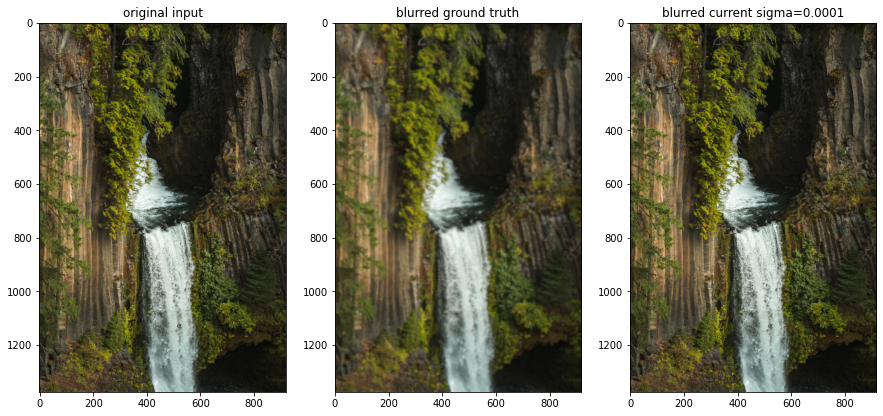

In [23]:
## plots using code from intenet: self.internet_make_gaussian()
plot_three_imgs(ipimg, blurimg_gt, conv2d_cv2, current_sigma)

## Calculating losses
### using this post: https://neptune.ai/blog/pytorch-loss-functions
### 1) Mean Absolute Error (L1 Loss Function): nn.L1Loss()
### 2) Mean Squared Error Loss Function: nn.MSELoss()

In [24]:
## 1) Mean Absolute Error (L1 Loss Function)
target = blurimg_gt_t
inp = torch.tensor(yhat, requires_grad=True)

mae_loss = nn.L1Loss()
output = mae_loss(inp, target)
output.backward()

#print(f"inp: {inp}")
#print(f"target: {target}")
print(f"output: {output}")

output: 0.04284335385708466


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
## 2) Mean Squared Error Loss Function (L2 loss)
target = blurimg_gt_t
inp = torch.tensor(yhat, requires_grad=True)

mse_loss = nn.MSELoss()
output = mae_loss(inp, target)
output.backward()

#print(f"inp: {inp}")
#print(f"target: {target}")
print(f"output: {output}")

In [25]:
my_model = GaussianSmoothing(calc_kernel_size, current_sigma, conv2d_stride, conv2d_padding,
                            conv2d_bias, conv2d_dilation, conv2d_groups)
x = ipimg_t
target = blurimg_gt_t

criterion = nn.MSELoss()

yhat = my_model(x)

loss = criterion(yhat, target)
print(loss)

for sigma = 0.0001, gaussian kernel size = torch.Size([3, 1, 7, 7])
tensor(0.0039, dtype=torch.float64)


## Trial and error method to esitmate the required sigma

## Thus pretty sure the desired sigma is 2.50

In [26]:
def get_loss_for_diff_sigma(_c_sigma):
    calc_kernel_size = 2*math.ceil(_c_sigma)*3 + 1
    conv2d_padding = (calc_kernel_size - 1) // 2
    ## update model with the new guassian  kernel based on the new sigma
    my_model = GaussianSmoothing(calc_kernel_size, _c_sigma, conv2d_stride, conv2d_padding,
                                conv2d_bias, conv2d_dilation, conv2d_groups)
    
    x = ipimg_t #torch.rand(1, 3, 100, 100)
    target = blurimg_gt_t

    criterion = nn.MSELoss()

    yhat = my_model(x)
    print(f"yhat.shape = {yhat.shape} , target.shape = {target.shape}")

    loss = criterion(yhat, target)
    print(f"sigma = {_c_sigma}, loss = {loss}\n")
    return loss

### lossMSE for sigma range 0.0001, 0.5 to 5.0 in steps of 0.5

In [27]:
np.concatenate( [np.asarray([0.0001]) , np.arange(0.5, 5.25, 0.5)] )

array([1.0e-04, 5.0e-01, 1.0e+00, 1.5e+00, 2.0e+00, 2.5e+00, 3.0e+00,
       3.5e+00, 4.0e+00, 4.5e+00, 5.0e+00])

In [28]:
# lossMSE for sigma range 0.0001, 0.5 to 5.0 in steps of 0.5
conv2d_bias = None
conv2d_stride = 1
#conv2d_padding = 3
#conv2d_padding = (calc_kernel_size - 1) // 2
#print(f"calculated kernel size = {calc_kernel_size} , calculated padding = {conv2d_padding}")
conv2d_dilation = 1
conv2d_groups = 3

loss_vs_sigma_0_to_4point5 = list()
#for c_sig in np.arange(1.0, 10.25, 1.0):
for c_sig in np.concatenate( [np.asarray([0.0001]) , np.arange(0.5, 5.0, 0.5)] ):
    c_loss = get_loss_for_diff_sigma(c_sig)
    loss_vs_sigma_0_to_4point5.append({'sigma': c_sig, 'lossMSE': float(c_loss.numpy())})
for idx, item in enumerate(loss_vs_sigma_0_to_4point5):
    print(f"{idx+1} : {item}")

for sigma = 0.0001, gaussian kernel size = torch.Size([3, 1, 7, 7])
yhat.shape = torch.Size([1, 3, 1375, 918]) , target.shape = torch.Size([1, 3, 1375, 918])
sigma = 0.0001, loss = 0.003904912545574814

for sigma = 0.5, gaussian kernel size = torch.Size([3, 1, 7, 7])
yhat.shape = torch.Size([1, 3, 1375, 918]) , target.shape = torch.Size([1, 3, 1375, 918])
sigma = 0.5, loss = 0.002634355241834369

for sigma = 1.0, gaussian kernel size = torch.Size([3, 1, 7, 7])
yhat.shape = torch.Size([1, 3, 1375, 918]) , target.shape = torch.Size([1, 3, 1375, 918])
sigma = 1.0, loss = 0.0011812048443116177

for sigma = 1.5, gaussian kernel size = torch.Size([3, 1, 13, 13])
yhat.shape = torch.Size([1, 3, 1375, 918]) , target.shape = torch.Size([1, 3, 1375, 918])
sigma = 1.5, loss = 0.0006170637632856388

for sigma = 2.0, gaussian kernel size = torch.Size([3, 1, 13, 13])
yhat.shape = torch.Size([1, 3, 1375, 918]) , target.shape = torch.Size([1, 3, 1375, 918])
sigma = 2.0, loss = 0.0003793856683723824

fo

In [ ]:
# lossMSE for sigma range 0.0001, 0.5 to 5.0
1 : {'sigma': 0.0001, 'lossMSE': 0.003904912545574814}
2 : {'sigma': 0.5, 'lossMSE': 0.002634355241834369}
3 : {'sigma': 1.0, 'lossMSE': 0.0011812048443116177}
4 : {'sigma': 1.5, 'lossMSE': 0.0006170637632856388}
5 : {'sigma': 2.0, 'lossMSE': 0.0003793856683723824}
6 : {'sigma': 2.5, 'lossMSE': 0.00031744706728745523}
7 : {'sigma': 3.0, 'lossMSE': 0.00035933049476959204}
8 : {'sigma': 3.5, 'lossMSE': 0.0004641789780205476}
9 : {'sigma': 4.0, 'lossMSE': 0.0006014877540831455}
10 : {'sigma': 4.5, 'lossMSE': 0.000764756241064032}

## based on above observation, the loss is least around sigma = 2.5
## reduced from sigma of 2.0 to 2.5, but then increases from sigma of 2.5 to 3.0

### lossMSE for sigma range 2.0 to 3.0, in steps of 0.1

In [29]:
np.arange(2.0, 3.1, 0.1)

array([2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ])

In [30]:
# lossMSE for sigma range 2.0 to 3.0, in steps of 0.1
conv2d_bias = None
conv2d_stride = 1
#conv2d_padding = 3
#conv2d_padding = (calc_kernel_size - 1) // 2
#print(f"calculated kernel size = {calc_kernel_size} , calculated padding = {conv2d_padding}")
conv2d_dilation = 1
conv2d_groups = 3

loss_vs_sigma_2_to_3 = list()
#for c_sig in np.concatenate( [np.asarray([0.0001]) , np.arange(0.5, 3.25, 0.5)] ):
for c_sig in np.arange(2.0, 3.1, 0.1):
    c_loss = get_loss_for_diff_sigma(c_sig)
    loss_vs_sigma_2_to_3.append({'sigma': c_sig, 'lossMSE': float(c_loss.numpy())})
for idx, item in enumerate(loss_vs_sigma_2_to_3):
    print(f"{idx+1} : {item}")

for sigma = 2.0, gaussian kernel size = torch.Size([3, 1, 13, 13])
yhat.shape = torch.Size([1, 3, 1375, 918]) , target.shape = torch.Size([1, 3, 1375, 918])
sigma = 2.0, loss = 0.0003793856683723824

for sigma = 2.1, gaussian kernel size = torch.Size([3, 1, 19, 19])
yhat.shape = torch.Size([1, 3, 1375, 918]) , target.shape = torch.Size([1, 3, 1375, 918])
sigma = 2.1, loss = 0.0003546237786417552

for sigma = 2.2, gaussian kernel size = torch.Size([3, 1, 19, 19])
yhat.shape = torch.Size([1, 3, 1375, 918]) , target.shape = torch.Size([1, 3, 1375, 918])
sigma = 2.2, loss = 0.0003375216885263133

for sigma = 2.3000000000000003, gaussian kernel size = torch.Size([3, 1, 19, 19])
yhat.shape = torch.Size([1, 3, 1375, 918]) , target.shape = torch.Size([1, 3, 1375, 918])
sigma = 2.3000000000000003, loss = 0.0003259981211835083

for sigma = 2.4000000000000004, gaussian kernel size = torch.Size([3, 1, 19, 19])
yhat.shape = torch.Size([1, 3, 1375, 918]) , target.shape = torch.Size([1, 3, 1375, 918]

In [ ]:
# lossMSE for sigma range 2.0 to 3.0, in steps of 0.1
1 : {'sigma': 2.0, 'lossMSE': 0.0003793856683723824}
2 : {'sigma': 2.1, 'lossMSE': 0.0003546237786417552}
3 : {'sigma': 2.2, 'lossMSE': 0.0003375216885263133}
4 : {'sigma': 2.3000000000000003, 'lossMSE': 0.0003259981211835083}
5 : {'sigma': 2.4000000000000004, 'lossMSE': 0.0003194789854177865}
6 : {'sigma': 2.5000000000000004, 'lossMSE': 0.00031744706728745463}
7 : {'sigma': 2.6000000000000005, 'lossMSE': 0.0003194318154356692}
8 : {'sigma': 2.7000000000000006, 'lossMSE': 0.00032500077903307073}
9 : {'sigma': 2.8000000000000007, 'lossMSE': 0.00033375284175879937}
10 : {'sigma': 2.900000000000001, 'lossMSE': 0.000345313277226439}
11 : {'sigma': 3.000000000000001, 'lossMSE': 0.0003604652950971858}

## based on above observation, the loss is least around sigma = 2.5
## reduced from sigma of 2.4 to 2.5, but then increases from sigma of 2.5 to 2.6

### lossMSE for sigma range 2.4 to 2.6, in steps of 0.01

In [31]:
# lossMSE for sigma range 2.4 to 2.6, in steps of 0.01
loss_vs_sigma_2point4_to_2point6 = list()
#for c_sig in np.concatenate( [np.asarray([0.0001]) , np.arange(0.5, 5.5, 0.5)] ):
for c_sig in np.arange(2.4, 2.6, 0.01):
    c_loss = get_loss_for_diff_sigma(c_sig)
    loss_vs_sigma_2point4_to_2point6.append({'sigma': c_sig, 'lossMSE': float(c_loss.numpy())})
for idx, item in enumerate(loss_vs_sigma_2point4_to_2point6):
    print(f"{idx+1} : {item}")

for sigma = 2.4, gaussian kernel size = torch.Size([3, 1, 19, 19])
yhat.shape = torch.Size([1, 3, 1375, 918]) , target.shape = torch.Size([1, 3, 1375, 918])
sigma = 2.4, loss = 0.0003194789854177853

for sigma = 2.4099999999999997, gaussian kernel size = torch.Size([3, 1, 19, 19])
yhat.shape = torch.Size([1, 3, 1375, 918]) , target.shape = torch.Size([1, 3, 1375, 918])
sigma = 2.4099999999999997, loss = 0.00031908196768661024

for sigma = 2.4199999999999995, gaussian kernel size = torch.Size([3, 1, 19, 19])
yhat.shape = torch.Size([1, 3, 1375, 918]) , target.shape = torch.Size([1, 3, 1375, 918])
sigma = 2.4199999999999995, loss = 0.00031872929458768044

for sigma = 2.4299999999999993, gaussian kernel size = torch.Size([3, 1, 19, 19])
yhat.shape = torch.Size([1, 3, 1375, 918]) , target.shape = torch.Size([1, 3, 1375, 918])
sigma = 2.4299999999999993, loss = 0.00031842048143712083

for sigma = 2.439999999999999, gaussian kernel size = torch.Size([3, 1, 19, 19])
yhat.shape = torch.Size([1

In [ ]:
# lossMSE for sigma range 2.4 to 2.6, in steps of 0.01
1 : {'sigma': 2.4, 'lossMSE': 0.0003194789854177853}
2 : {'sigma': 2.4099999999999997, 'lossMSE': 0.00031908196768661024}
3 : {'sigma': 2.4199999999999995, 'lossMSE': 0.00031872929458768044}
4 : {'sigma': 2.4299999999999993, 'lossMSE': 0.00031842048143712083}
5 : {'sigma': 2.439999999999999, 'lossMSE': 0.0003181550480043205}
6 : {'sigma': 2.449999999999999, 'lossMSE': 0.00031793251842164404}
7 : {'sigma': 2.4599999999999986, 'lossMSE': 0.00031775242109586074}
8 : {'sigma': 2.4699999999999984, 'lossMSE': 0.00031761428862130044}
9 : {'sigma': 2.479999999999998, 'lossMSE': 0.0003175176576947823}
10 : {'sigma': 2.489999999999998, 'lossMSE': 0.0003174620690322847}
11 : {'sigma': 2.499999999999998, 'lossMSE': 0.0003174470672874551}
12 : {'sigma': 2.5099999999999976, 'lossMSE': 0.0003174722009718658}
13 : {'sigma': 2.5199999999999974, 'lossMSE': 0.00031753702237713314}
14 : {'sigma': 2.529999999999997, 'lossMSE': 0.000317641087498837}
15 : {'sigma': 2.539999999999997, 'lossMSE': 0.00031778395596230045}
16 : {'sigma': 2.5499999999999967, 'lossMSE': 0.0003179651909501981}
17 : {'sigma': 2.5599999999999965, 'lossMSE': 0.0003181843591320421}
18 : {'sigma': 2.5699999999999963, 'lossMSE': 0.0003184410305955162}
19 : {'sigma': 2.579999999999996, 'lossMSE': 0.00031873477877969323}
20 : {'sigma': 2.589999999999996, 'lossMSE': 0.00031906518041009875}
21 : {'sigma': 2.5999999999999956, 'lossMSE': 0.0003194318154356674}

## based on above observation, the loss is least around sigma = 2.5
## reduced from sigma of 2.49 to 2.50, but then increases from sigma of 2.50 to 2.51
10 : {'sigma': 2.489999999999998, 'lossMSE': 0.0003174620690322847}
11 : {'sigma': 2.499999999999998, 'lossMSE': 0.0003174470672874551}
12 : {'sigma': 2.5099999999999976, 'lossMSE': 0.0003174722009718658}

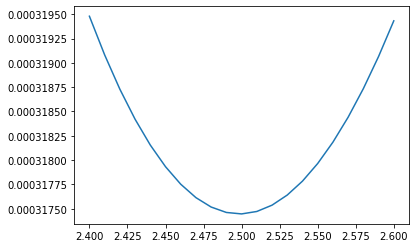

In [32]:
## plot clearly shows lowest MSE at 2.5
plt.plot([item['sigma'] for item in loss_vs_sigma_2point4_to_2point6], [item['lossMSE'] for item in loss_vs_sigma_2point4_to_2point6], label="lossMSE")

## version 1: this model definition allows the kernel weights itself to be updated - not the sigma value
## using two parameters for the conv matrix's weight and bias

In [34]:
#let this fail - it worked, but using two parameters for the convolution weights and the bias
## this model definition allows the kernel weights itself to be updated - not the sigma value

class model_GaussianSmoothing(nn.Module):
    """
    1) function make_gaussian_filter_FINAL(): uses the gaussian_filter from scipy.ndimage
    2) function internet_make_gaussian(): explicity defines the gaussian filter code
       code found here: https://discuss.pytorch.org/t/is-there-anyway-to-do-gaussian-filtering-for-an-image-2d-3d-in-pytorch/12351/9
    """
    def __init__(self, _kernel_size_number, _in_sigma, _conv2d_stride, _conv2d_padding,
                _conv2d_bias, _conv2d_dilation, _conv2d_groups,
                _conv2d_weight=None):
        super(model_GaussianSmoothing, self).__init__()
        
        self.curr_sigma = _in_sigma
        
        g_kernel = self.internet_make_gaussian(_kernel_size_number, self.curr_sigma)
        
        self.conv2d_weight = g_kernel
        
        self.conv2d_bias = _conv2d_bias
        self.conv2d_stride = _conv2d_stride
        self.conv2d_padding = _conv2d_padding
        self.conv2d_dilation  = _conv2d_dilation
        self.groups = _conv2d_groups
        
        ## earlier version - conv1_weight was allowed to be updated with gradient
        ##                   descent but not sigma itself
        ##                   using two parameters for the conv matrix's weight and bias
        self.conv1_weight = nn.Parameter(self.conv2d_weight, requires_grad=True)
        self.conv1_bias = nn.Parameter(self.conv2d_bias, requires_grad=True)
    
    def internet_make_gaussian(self, _kernel_size_number, _in_sigma, _dim=2, _channels=3):
        ## from https://discuss.pytorch.org/t/is-there-anyway-to-do-gaussian-filtering-for-an-image-2d-3d-in-pytorch/12351/9
        
        if isinstance(_kernel_size_number, numbers.Number):
            kernel_size = [_kernel_size_number] * _dim
        if isinstance(_in_sigma, numbers.Number):
            sigma = [_in_sigma] * _dim

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        meshgrids = torch.meshgrid(
            [
                torch.arange(size, dtype=torch.float64)
                for size in kernel_size
            ]
        )
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / std) ** 2 / 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(_channels, *[1] * (kernel.dim() - 1))
        print(f"make_gaussion function: sigma = {_in_sigma}, gaussian kernel size = {kernel.shape}")
        return kernel

    def forward(self, x):
        x = F.conv2d(x, weight=self.conv1_weight,
                     bias=self.conv1_bias,
                     groups=self.groups, padding=self.conv2d_padding,
                     stride=self.conv2d_stride)
        return x

In [35]:
start_sigma = 0.0001
calc_kernel_size = 2*math.ceil(start_sigma)*3 + 1
print(f"with Sigma = {start_sigma} , calculated kernel size = {calc_kernel_size}")

with Sigma = 0.0001 , calculated kernel size = 7


In [36]:
## for model definition allowing the kernel weights itself to be updated - not the sigma value
##     so here the conv2d function bias itself is used and does not remain None. Needs a tensor of 3 values.
conv2d_bias = torch.randn(3)

conv2d_stride = 1
conv2d_padding = (calc_kernel_size - 1) // 2
print(f"calculated kernel size = {calc_kernel_size} , calculated padding = {conv2d_padding}")
conv2d_dilation = 1
conv2d_groups = 3

calculated kernel size = 7 , calculated padding = 3


In [37]:
## for model definition allowing the kernel weights itself to be updated - not the sigma value
my_model = model_GaussianSmoothing(calc_kernel_size, start_sigma, conv2d_stride, conv2d_padding,
                            conv2d_bias, conv2d_dilation, conv2d_groups)

make_gaussion function: sigma = 0.0001, gaussian kernel size = torch.Size([3, 1, 7, 7])


In [38]:
for param, param_val in zip(my_model.state_dict(), my_model.parameters()):
    print(f"{param}: {param_val}")

conv1_weight: Parameter containing:
tensor([[[[0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.]]]], dtype=torch.float64,
       requires_grad=True)
conv1_bias: Parameter containing:
tensor([-0.7552, -1.1349,  0.40

In [39]:
print(ipimg_t.shape, blurimg_gt_t.shape, my_model.conv2d_weight.shape)

torch.Size([1, 3, 1375, 918]) torch.Size([1, 3, 1375, 918]) torch.Size([3, 1, 7, 7])


Parameters BEFORE gradient descent :
conv1_weight: Parameter containing:
tensor([[[[0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0.]]]], dtype=torch.float64,
       requires_grad=True)
conv1_bias: Parameter contai

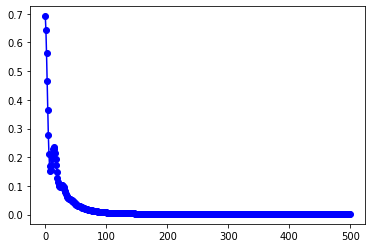

In [40]:
x = ipimg_t
target = blurimg_gt_t

criterion = nn.MSELoss()

#Optimizing
optimizer = torch.optim.SGD(my_model.parameters(), lr=0.01, momentum=0.9)
#optimizer = torch.optim.Adam([var1, var2], lr=0.0001)
#optimizer = torch.optim.SGD(my_model.parameters(), lr=0.01)

criterion = nn.MSELoss()
# In training loop
n_epochs = 500
loss_values = []
for i in range(n_epochs):
    optimizer.zero_grad() # equivalent to net.zero_grad()
    yhat = my_model(x) #output = net(x)
    loss = criterion(yhat, target) #loss = criterion(output,y)
    ## paremeters before starting training
    if i == 0:
        print("Parameters BEFORE gradient descent :")
        for param, param_val in zip(my_model.state_dict(), my_model.parameters()):
            print(f"{param}: {param_val}")
    loss.backward()
    optimizer.step()
    ## print the loss
    #print(f"iter={i}, Loss_MSE={loss}")
    if (i+1) % 25 == 0:
        print(f"iter={i}, Loss_MSE={loss}")
    ## print the parameters
    if (i+1) % 100 == 0:
        print(f"{param}: {param_val}")
    loss_values.append(loss.item())

## plot loss
plt.plot(loss_values, label="lossMSE vs epoch", marker='o', color='blue')

In [41]:
for idx, loss_val in enumerate(loss_values):
    if idx%50 == 0:
        print(f"iter={idx} , loss = {loss_val}")

iter=0 , loss = 0.6915355183119962
iter=50 , loss = 0.035558953148627004
iter=100 , loss = 0.0071442896751117224
iter=150 , loss = 0.003470269470495822
iter=200 , loss = 0.0028589854255531926
iter=250 , loss = 0.002653486924656246
iter=300 , loss = 0.002513593902380171
iter=350 , loss = 0.0023937281195949033
iter=400 , loss = 0.002286498508162978
iter=450 , loss = 0.0021896738042015795


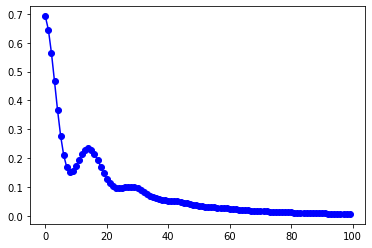

In [42]:
## plot loss
plt.plot(loss_values[:100], label="lossMSE vs epoch", marker='o', color='blue')

In [43]:
print("Parameters AFTER training :")
for param, param_val in zip(my_model.state_dict(), my_model.parameters()):
    print(f"{param}: {param_val}")

Parameters AFTER training :
conv1_weight: Parameter containing:
tensor([[[[ 2.0195e-02,  1.2688e-02,  5.8060e-03,  4.0608e-03,  1.3633e-02,
            2.2188e-02,  2.9598e-02],
          [ 1.6299e-02,  5.1520e-03, -8.7532e-03, -1.4332e-02,  2.9466e-03,
            1.6119e-02,  2.4815e-02],
          [ 1.4789e-02, -8.3421e-04, -3.2231e-02, -5.9807e-02, -1.9078e-02,
            8.5079e-03,  2.0379e-02],
          [ 1.6433e-02,  2.1971e-04, -4.6874e-02,  8.8236e-01, -4.6918e-02,
            2.5639e-04,  1.6445e-02],
          [ 2.0333e-02,  8.4500e-03, -1.9040e-02, -5.9802e-02, -3.2266e-02,
           -8.0447e-04,  1.4782e-02],
          [ 2.4707e-02,  1.6001e-02,  2.9394e-03, -1.4357e-02, -8.8039e-03,
            5.1595e-03,  1.6269e-02],
          [ 2.9526e-02,  2.2103e-02,  1.3657e-02,  4.0909e-03,  5.8222e-03,
            1.2767e-02,  2.0236e-02]]],


        [[[ 1.9791e-02,  1.2261e-02,  6.3298e-03,  5.6618e-03,  1.4296e-02,
            2.2391e-02,  3.0306e-02],
          [ 1.5300e-

In [47]:
print("Parameters AFTER training :")
for name, param in my_model.named_parameters():
    print(f"{name}: {param}")

Parameters AFTER training :
conv1_weight: Parameter containing:
tensor([[[[ 2.0195e-02,  1.2688e-02,  5.8060e-03,  4.0608e-03,  1.3633e-02,
            2.2188e-02,  2.9598e-02],
          [ 1.6299e-02,  5.1520e-03, -8.7532e-03, -1.4332e-02,  2.9466e-03,
            1.6119e-02,  2.4815e-02],
          [ 1.4789e-02, -8.3421e-04, -3.2231e-02, -5.9807e-02, -1.9078e-02,
            8.5079e-03,  2.0379e-02],
          [ 1.6433e-02,  2.1971e-04, -4.6874e-02,  8.8236e-01, -4.6918e-02,
            2.5639e-04,  1.6445e-02],
          [ 2.0333e-02,  8.4500e-03, -1.9040e-02, -5.9802e-02, -3.2266e-02,
           -8.0447e-04,  1.4782e-02],
          [ 2.4707e-02,  1.6001e-02,  2.9394e-03, -1.4357e-02, -8.8039e-03,
            5.1595e-03,  1.6269e-02],
          [ 2.9526e-02,  2.2103e-02,  1.3657e-02,  4.0909e-03,  5.8222e-03,
            1.2767e-02,  2.0236e-02]]],


        [[[ 1.9791e-02,  1.2261e-02,  6.3298e-03,  5.6618e-03,  1.4296e-02,
            2.2391e-02,  3.0306e-02],
          [ 1.5300e-

In [57]:
#print(my_model)
summary(my_model, (1, 3, 1, 7, 7))

RuntimeError: ignored

## version 3: not allowing the kernel weights itself to be updated, but the the sigma value
##            no model class, direct code

In [ ]:
start_sigma = 0.0001
calc_kernel_size = 2*math.ceil(start_sigma)*3 + 1
print(f"with Sigma = {start_sigma} , calculated kernel size = {calc_kernel_size}")

In [ ]:
## not allowing the kernel weights itself to be updated, but the the sigma value
conv2d_bias = None

conv2d_stride = 1
conv2d_padding = (calc_kernel_size - 1) // 2
print(f"calculated kernel size = {calc_kernel_size} , calculated padding = {conv2d_padding}")
conv2d_dilation = 1
conv2d_groups = 3

In [ ]:
#print(ipimg_t.shape, blurimg_gt_t.shape, my_model.conv2d_weight.shape)
print(f"ipimg_t.shape = {ipimg_t.shape}, blurimg_gt_t.shape = {blurimg_gt_t.shape}")
print(f"ipimg_t size = {ipimg_t.size()}")  # (C,H, W), channel order (B, G, R)
print(f"blurimg_gt_t size = {blurimg_gt_t.size()}")  # (C,H, W), channel order (B, G, R)
print(f"ipimg_t.dtype = {ipimg_t.dtype}, blurimg_gt_t.dtype = {blurimg_gt_t.dtype}")
print(f"my_model.conv2d_weight.shape = {my_model.conv2d_weight.shape}")

In [ ]:
def outerFunction_internet_make_gaussian(self, _kernel_size_number, _in_sigma, _dim=2, _channels=3):
    ## from https://discuss.pytorch.org/t/is-there-anyway-to-do-gaussian-filtering-for-an-image-2d-3d-in-pytorch/12351/9

    if isinstance(_kernel_size_number, numbers.Number):
        kernel_size = [_kernel_size_number] * _dim
    if isinstance(_in_sigma, numbers.Number):
        sigma = [_in_sigma] * _dim

    # The gaussian kernel is the product of the
    # gaussian function of each dimension.
    kernel = 1
    meshgrids = torch.meshgrid(
        [
            torch.arange(size, dtype=torch.float64)
            for size in kernel_size
        ]
    )
    for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
        mean = (size - 1) / 2
        kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                  torch.exp(-((mgrid - mean) / std) ** 2 / 2)

    # Make sure sum of values in gaussian kernel equals 1.
    kernel = kernel / torch.sum(kernel)

    # Reshape to depthwise convolutional weight
    kernel = kernel.view(1, 1, *kernel.size())
    kernel = kernel.repeat(_channels, *[1] * (kernel.dim() - 1))
    print(f"make_gaussion function: sigma = {_in_sigma}, gaussian kernel size = {kernel.shape}")
    return kernel

In [ ]:
x = ipimg_t
target = blurimg_gt_t
criterion = nn.MSELoss()
#yhat = my_model(x)

start_sigma = 0.0001
calc_kernel_size = 2*math.ceil(start_sigma)*3 + 1
print(f"with Sigma = {start_sigma} , calculated kernel size = {calc_kernel_size}")
## not allowing the kernel weights itself to be updated, but the the sigma value
outer_conv2d_bias = None
outer_conv2d_stride = 1
outer_conv2d_padding = (calc_kernel_size - 1) // 2
print(f"calculated kernel size = {calc_kernel_size} , calculated padding = {conv2d_padding}")
outer_conv2d_dilation = 1
outer_conv2d_groups = 3

outer_conv2d_weight = outerFunction_internet_make_gaussian(
    _kernel_size_number=calc_kernel_size,
    _in_sigma=start_sigma)

yhat = 
yhat = F.conv2d(x, weight=outer_conv2d_weight,
                bias=None,  ## ignore any bias value that may have been sent as it should only be for the sigma parameter
                groups=outer_conv2d_groups, padding=outer_conv2d_padding,
                stride=outer_conv2d_stride)

loss = criterion(yhat, target) #loss = criterion(output,y)

print(yhat.shape)